In [1]:
# imports as per

import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# variable declaration

nx = 81
ny = 81
nt = 200

nit = 50

c = 1

dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
dt = 0.001

x = numpy.linspace(0, 2, nx)
y = numpy.linspace(0, 2, ny)

X, Y = numpy.meshgrid(x, y)

rho = 1
nu = 0.1

u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx))
b = numpy.zeros((ny, nx))

In [3]:
# define a function that outputs the terms in the square brackets in the pressure equations

def build_b(dx, dy, dt, u, v, rho, b):
    
    b[1:-1, 1:-1] = ((rho * dx ** 2 * dy ** 2) / (2 * (dx ** 2 + dy ** 2)) 
                     
                     * ((1 / dt) * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))
                                    
                                    - ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx)) ** 2
                                    
                                    - 2 * (u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) * (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx)
                                    
                                    - ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) ** 2))
    
    return b

In [4]:
# iterative function to get the pressure field

def pressure_poisson(dx, dy, b, p, nit):
    
    pn = numpy.empty_like(p)
    pn = p.copy()
    
    for q in range(nit):
        
        pn = p.copy()     
        
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy ** 2 + 
                         
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx ** 2) / (2 * (dx ** 2 + dy ** 2)) -
                        
                          b[1:-1, 1:-1])
        
        p[-1, :] = 0 # p = 0 at y = 0
        p[0, :] = p[1, :] # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1] # dp/dx = 0 at x = 0
        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        
    return p

In [5]:
# function to output u

def build_u(dx, dy, dt, u, v, p, nu):
    
    un = u.copy()
    
    u[1:-1, 1:-1] = (un[1:-1, 1:-1] - un[1:-1, 1:-1] * (dt / dx) * (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                     
                                     v[1:-1, 1:-1] * (dt / dy) * (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                    
                                     (dt / (2 * rho * dx)) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                    
                    nu * ( (dt / dx ** 2) * (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                          
                           (dt / dy ** 2) * (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))
    
    return u

In [6]:
# function to output v

def build_v(dx, dy, dt, u, v, p, nu):
    
    vn = v.copy()
    
    v[1:-1, 1:-1] = (vn[1:-1, 1:-1] - u[1:-1, 1:-1] * (dt / dx) * (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                     
                                     vn[1:-1, 1:-1] * (dt / dy) * (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                    
                                     (dt / (2 * rho * dy)) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                    
                    nu * ( (dt / dx ** 2) * (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                          
                           (dt / dy ** 2) * (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
    
    return v

In [7]:
# cavity flow solver

def cavity_flow(dx, dy, dt, u, v, p, b, nt, nit, rho, nu):
    
    un = numpy.empty_like(u)
    vn = numpy.empty_like(v)
    
    b = numpy.zeros((ny, nx))
    
    for n in range(nt):
        
        un = u.copy()
        vn = v.copy()
        
        b = build_b(dx, dy, dt, u, v, rho, b)
        p = pressure_poisson(dx, dy, b, p, nit)
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1] - un[1:-1, 1:-1] * (dt / dx) * (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                     
                                     vn[1:-1, 1:-1] * (dt / dy) * (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                    
                                     (dt / (2 * rho * dx)) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                    
                    nu * ( (dt / dx ** 2) * (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                          
                           (dt / dy ** 2) * (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))
        
        
        v[1:-1, 1:-1] = (vn[1:-1, 1:-1] - un[1:-1, 1:-1] * (dt / dx) * (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                     
                                     vn[1:-1, 1:-1] * (dt / dy) * (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                    
                                     (dt / (2 * rho * dy)) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                    
                    nu * ( (dt / dx ** 2) * (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                          
                           (dt / dy ** 2) * (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
        
        # boundary conditions
        
        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    # velocity at cavity lid = 1
        
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        
    return u, v, p

In [8]:
u, v, p = cavity_flow(dx, dy, dt, u, v, p, b, nt, nit, rho, nu)

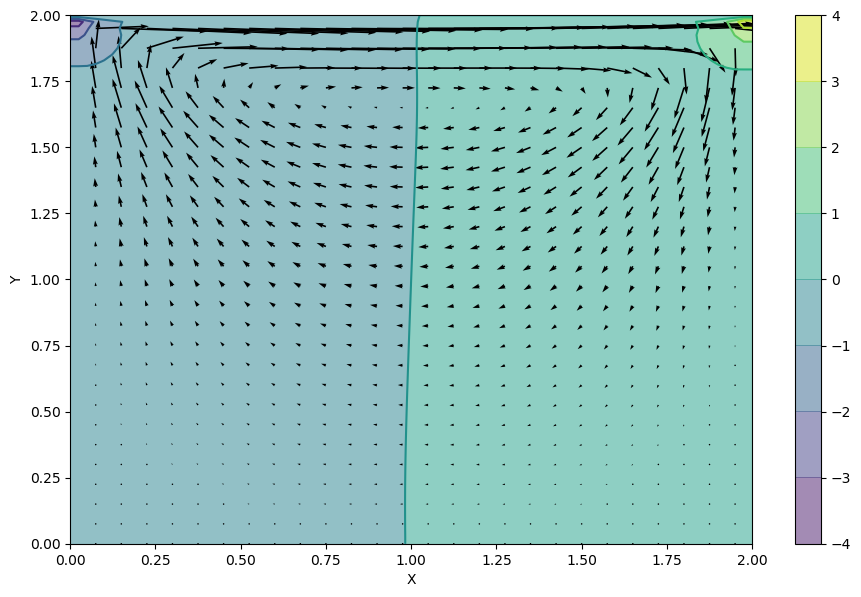

In [9]:
# visualise results

fig = pyplot.figure(figsize=(11,7), dpi=100)

# plotting the pressure field as a contour

pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()

# plotting the pressure field outlines

pyplot.contour(X, Y, p, cmap=cm.viridis)  

# plotting velocity field

pyplot.quiver(X[::3, ::3], Y[::3, ::3], u[::3, ::3], v[::3, ::3]) 
pyplot.xlabel('X')
pyplot.ylabel('Y');